# Multi-Disease Prediction from Symptoms

This notebook trains an XGBoost classifier to predict diseases based on patient symptoms.

**Dataset:** 41 diseases with symptom combinations  
**Model:** XGBoost Multi-class Classifier  
**Features:** One-hot encoded symptoms

## 1. Import Libraries

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import preprocessing
import xgboost as xgb
import joblib
import gzip

# Set plot styles
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


## 2. Load Dataset

In [30]:
# Load the raw dataset
dataset_df = pd.read_csv('../Frontend/data/dataset.csv')

print(f"Dataset shape: {dataset_df.shape}")
print(f"\nFirst few rows:")
display(dataset_df.head())

print(f"\nUnique diseases: {dataset_df['Disease'].nunique()}")
print(f"\nDisease distribution:")
print(dataset_df['Disease'].value_counts().head(10))

Dataset shape: (4930, 18)

First few rows:


,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Unique diseases: 42

Disease distribution:
Disease
Fungal infection                120
Hypothyroidism                  120
Hepatitis E                     120
Alcoholic hepatitis             120
Tuberculosis                    120
Common Cold                     120
Pneumonia                       120
Dimorphic hemmorhoids(piles)    120
Heart attack                    120
Varicose veins                  120
Name: count, dtype: int64


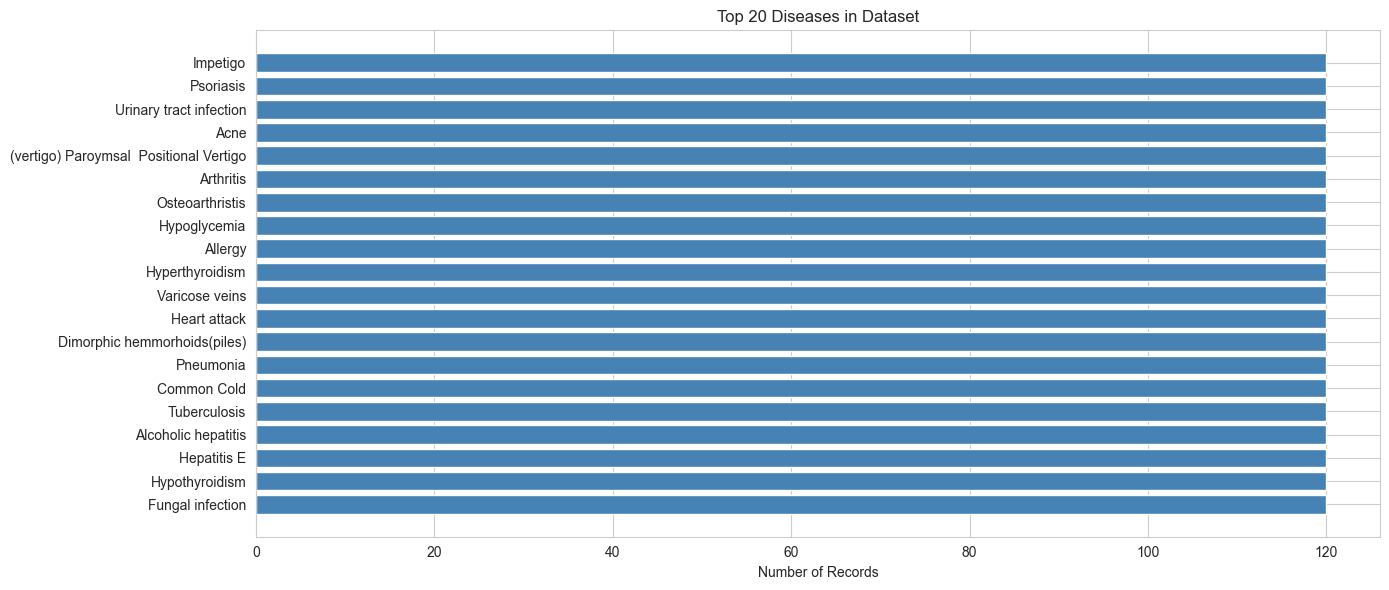

In [31]:
# Visualize disease distribution
plt.figure(figsize=(14, 6))
disease_counts = dataset_df['Disease'].value_counts().head(20)
plt.barh(disease_counts.index, disease_counts.values, color='steelblue')
plt.xlabel('Number of Records')
plt.title('Top 20 Diseases in Dataset')
plt.tight_layout()
plt.show()

## 3. Data Preprocessing

In [32]:
# Strip whitespace from all string columns
dataset_df = dataset_df.apply(lambda col: col.str.strip() if col.dtype == 'object' else col)

print("✓ Whitespace stripped from all columns")

✓ Whitespace stripped from all columns


In [33]:
# One-hot encode symptoms (all columns except Disease)
symptom_cols = [col for col in dataset_df.columns if col.startswith('Symptom')]
print(f"Encoding {len(symptom_cols)} symptom columns...")

# Get dummies for all symptom columns
test = pd.get_dummies(dataset_df.filter(regex='Symptom'), prefix='', prefix_sep='')

# Group by column name and take max (handles duplicate symptom columns)
test = test.groupby(test.columns, axis=1).agg(np.max)

print(f"\nOne-hot encoded shape: {test.shape}")
print(f"Total unique symptoms: {test.shape[1]}")

Encoding 17 symptom columns...

One-hot encoded shape: (4930, 133)
Total unique symptoms: 133


C:\Users\tan20\AppData\Local\Temp\ipykernel_10376\21426600.py:9: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  test = test.groupby(test.columns, axis=1).agg(np.max)
C:\Users\tan20\AppData\Local\Temp\ipykernel_10376\21426600.py:9: FutureWarning: The provided callable <function max at 0x000002466A75AB60> is currently using DataFrameGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  test = test.groupby(test.columns, axis=1).agg(np.max)


In [34]:
# Merge one-hot encoded symptoms with disease labels
clean_df = pd.merge(test, dataset_df['Disease'], left_index=True, right_index=True)

print(f"Clean dataset shape: {clean_df.shape}")
display(clean_df.head())

# Save cleaned dataset
clean_df.to_csv('../Frontend/data/clean_dataset.tsv', sep='\t', index=False)
print("\n✓ Clean dataset saved to: ../Frontend/data/clean_dataset.tsv")

Clean dataset shape: (4930, 134)


,abdominal_pain,abnormal_menstruation,acidity,acute_liver_failure,altered_sensorium,anxiety,back_pain,belly_pain,blackheads,bladder_discomfort,...,watering_from_eyes,weakness_in_limbs,weakness_of_one_body_side,weight_gain,weight_loss,yellow_crust_ooze,yellow_urine,yellowing_of_eyes,yellowish_skin,Disease
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Fungal infection
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Fungal infection
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Fungal infection
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Fungal infection
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Fungal infection



✓ Clean dataset saved to: ../Frontend/data/clean_dataset.tsv


## 4. Prepare Training Data

In [35]:
# Separate features and target
X_data = clean_df.iloc[:, :-1]  # All columns except last (Disease)
y_data = clean_df.iloc[:, -1]   # Disease column

print(f"Feature shape: {X_data.shape}")
print(f"Target shape: {y_data.shape}")
print(f"\nTarget classes: {y_data.nunique()}")

Feature shape: (4930, 133)
Target shape: (4930,)

Target classes: 42


In [36]:
# Convert disease names to categorical codes
y_data = y_data.astype('category')

# Fit label encoder
le = preprocessing.LabelEncoder()
le.fit(y_data)

print(f"Label encoder fitted with {len(le.classes_)} classes")
print(f"\nSample disease-to-code mapping:")
for i, disease in enumerate(le.classes_[:10]):
    print(f"  {i}: {disease}")

Label encoder fitted with 42 classes

Sample disease-to-code mapping:
  0: (vertigo) Paroymsal  Positional Vertigo
  1: AIDS
  2: Acne
  3: Alcoholic hepatitis
  4: Allergy
  5: Arthritis
  6: Bronchial Asthma
  7: Cervical spondylosis
  8: Chicken pox
  9: Chronic cholestasis


In [37]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, 
    test_size=0.2, 
    random_state=42
)

# Transform labels to numeric codes
y_train_encoded = le.transform(y_train)
y_test_encoded = le.transform(y_test)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (3944, 133)
Test set: (986, 133)


## 5. Train XGBoost Model

### XGBoost Optimizer Explanation

**Gradient Boosting Optimization:**

XGBoost uses **Gradient Descent** optimization with the following key components:

1. **Objective Function**: Minimizes `multi:softprob` (multi-class softmax probability)
2. **Learning Rate (eta)**: Controls step size during optimization (0.1)
3. **Tree Method**: Algorithm for finding best split points
4. **Boosting Strategy**: Sequentially builds trees to minimize residual errors

**How it works:**
- Each new tree is fitted to the gradient (derivative) of the loss function
- Trees are added to minimize the overall loss function
- Learning rate scales the contribution of each tree
- Process repeats for n_estimators iterations (200 trees)

In [38]:
# Initialize XGBoost classifier with optimizer settings
# XGBoost uses Gradient Descent optimization internally
model = xgb.XGBClassifier(
    objective='multi:softprob',  # Uses softmax + gradient descent
    num_class=len(le.classes_),
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,  # Optimizer step size (eta)
    random_state=42,
    eval_metric='mlogloss',  # Multi-class log loss
    tree_method='auto',  # Optimizer method: 'auto', 'exact', 'approx', 'hist'
    booster='gbtree'  # Gradient boosting with trees
)

print("🔧 Optimizer: Gradient Descent (built-in XGBoost)")
print(f"   - Learning Rate (eta): {model.learning_rate}")
print(f"   - Tree Method: {model.tree_method}")
print(f"   - Booster: {model.booster}\n")

print("Training XGBoost classifier...\n")

# Train with evaluation set to track loss
eval_set = [(X_train, y_train_encoded), (X_test, y_test_encoded)]
model.fit(
    X_train, y_train_encoded,
    eval_set=eval_set,
    verbose=False
)

print("✓ Model training complete!")

🔧 Optimizer: Gradient Descent (built-in XGBoost)
   - Learning Rate (eta): 0.1
   - Tree Method: auto
   - Booster: gbtree

Training XGBoost classifier...

✓ Model training complete!
✓ Model training complete!


## 6. Model Evaluation

In [39]:
# Make predictions
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"="*60)
print(f"Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"="*60)

Test Accuracy: 1.0000 (100.00%)


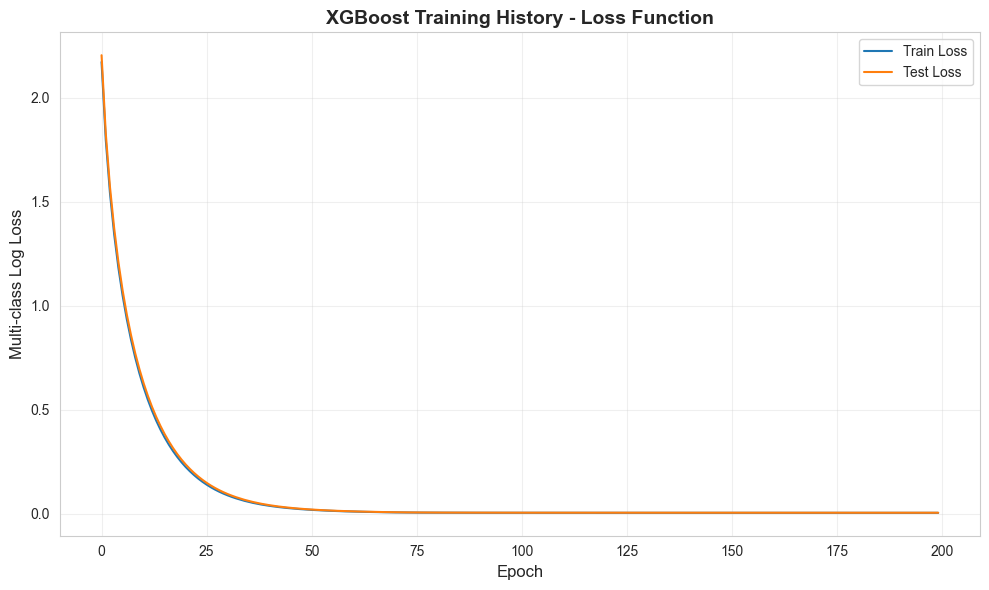

Final Training Loss: 0.0054
Final Test Loss: 0.0059


In [40]:
# Plot training and validation loss curves
results = model.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train Loss')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test Loss')
ax.legend()
ax.set_ylabel('Multi-class Log Loss', fontsize=12)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_title('XGBoost Training History - Loss Function', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final Training Loss: {results['validation_0']['mlogloss'][-1]:.4f}")
print(f"Final Test Loss: {results['validation_1']['mlogloss'][-1]:.4f}")

In [41]:
# Classification report
print("\nClassification Report:")
print("="*60)
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_, zero_division=0))


Classification Report:
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        20
                                   AIDS       1.00      1.00      1.00        32
                                   Acne       1.00      1.00      1.00        22
                    Alcoholic hepatitis       1.00      1.00      1.00        24
                                Allergy       1.00      1.00      1.00        25
                              Arthritis       1.00      1.00      1.00        20
                       Bronchial Asthma       1.00      1.00      1.00        25
                   Cervical spondylosis       1.00      1.00      1.00        25
                            Chicken pox       1.00      1.00      1.00        26
                    Chronic cholestasis       1.00      1.00      1.00        23
                            Common Cold       1.00      1.00      1.00        22
   

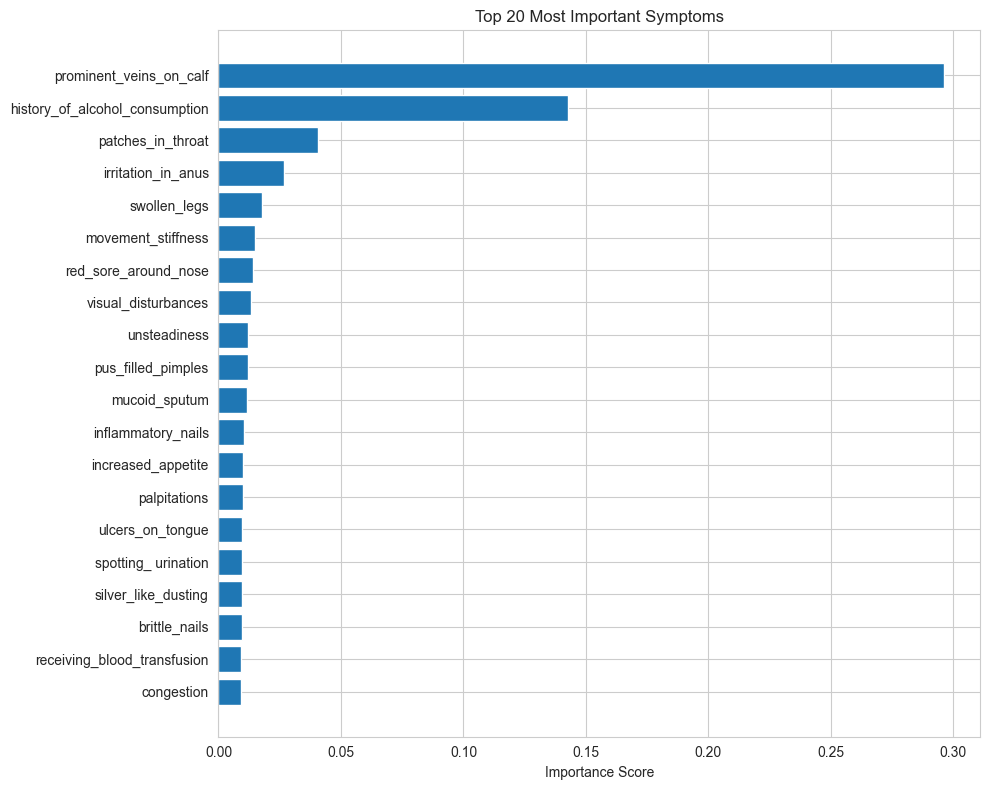


Top 10 most important symptoms:
                       symptom  importance
       prominent_veins_on_calf    0.296056
history_of_alcohol_consumption    0.142747
             patches_in_throat    0.040441
            irritation_in_anus    0.026718
                  swollen_legs    0.017964
            movement_stiffness    0.014851
          red_sore_around_nose    0.013891
           visual_disturbances    0.013206
                  unsteadiness    0.012194
            pus_filled_pimples    0.012152


In [42]:
# Feature importance (top 20 symptoms)
feature_importance = pd.DataFrame({
    'symptom': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
top_features = feature_importance.head(20)
plt.barh(top_features['symptom'], top_features['importance'])
plt.xlabel('Importance Score')
plt.title('Top 20 Most Important Symptoms')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 most important symptoms:")
print(feature_importance.head(10).to_string(index=False))